In [1]:
import tltorch
import torch

In [2]:
device='cpu'
input_channels = 16
output_channels = 32
kernel_size = 3
batch_size = 2
size = 24
order = 2

input_shape = (batch_size, input_channels) + (size, )*order
kernel_shape = (output_channels, input_channels) + (kernel_size, )*order

data = torch.randn(input_shape, dtype=torch.float32, device=device)

In [3]:
conv = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
fact_conv = tltorch.FactorizedConv(input_channels, output_channels, kernel_size=3, order=2, rank='same')
fact_conv2 = tltorch.FactorizedConv.from_conv(conv, rank='same', decompose_weights=True, factorization='tucker')

In [4]:
A = torch.randn((3, 3))
B = tltorch.FactorizedTensor.new(A, rank=0.1, factorization='CP')
B

TypeError: prod() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: axis, out
 * (int dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (name dim, bool keepdim = False, *, torch.dtype dtype = None)


In [ ]:
X_fact = fact_conv(data)
X_fact2 = fact_conv2(data)
X = conv(data)
X_fact2.sum()
X

tensor([[[[-7.9552e-02,  1.9379e-01,  4.9164e-01,  ..., -3.5606e-01,
           -3.1255e-02,  4.7891e-01],
          [-5.0889e-01,  4.7989e-02, -4.9427e-01,  ..., -5.7088e-01,
           -2.4230e-01,  1.2803e-01],
          [-3.9932e-02,  3.8377e-01, -3.7730e-01,  ..., -3.8390e-01,
            6.8876e-01, -6.2950e-04],
          ...,
          [ 1.5322e-01,  3.1423e-01,  1.0826e-01,  ..., -8.8554e-01,
           -4.1465e-01,  1.8086e-01],
          [-1.3579e-01, -3.6637e-01, -8.9709e-01,  ..., -3.9979e-01,
           -2.1472e-01, -5.3795e-01],
          [-5.8047e-01,  3.9616e-01, -2.9189e-01,  ...,  2.6079e-01,
           -8.1252e-01, -3.7589e-01]],

         [[-4.5905e-01,  3.2586e-01, -5.3513e-01,  ..., -1.6596e-01,
            2.3108e-01, -6.6711e-02],
          [-3.7288e-01,  4.0551e-02,  5.5917e-01,  ..., -1.2492e-01,
           -1.6621e-01, -1.1695e-01],
          [ 1.0548e+00, -6.1742e-01,  1.2730e-01,  ..., -1.8785e-02,
           -4.6965e-01,  4.8492e-01],
          ...,
     

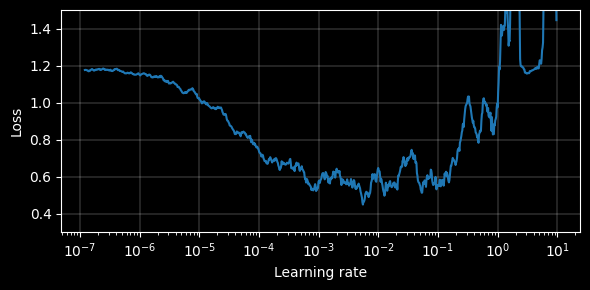

In [12]:
import numpy as np 
import matplotlib.pyplot as plt

lr_loss = np.load("lr_range_test.npy")

window = 20
loss_ma = np.convolve(lr_loss[:, 1], np.ones(window)/window, mode='same')

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(6, 3))
# ax.plot(lr_loss[:, 0], lr_loss[:, 1], '-', label='raw loss')
ax.plot(lr_loss[10:-2, 0], loss_ma[10:-2], '-', color='#1f77b4', label='moving average')
ax.set_xlabel("Learning rate")
ax.set_ylabel("Loss")
ax.set_xscale('log')
ax.set_ylim(0.3, 1.5)
ax.grid(which="major", linestyle='-', linewidth=0.2)
plt.tight_layout()
fig.savefig("results/lr_range_test.png")